# <center> **Анализ результатов A/B-тестирования**

## **Введение**

**A/B-тестирование** — это настоящий эксперимент, в котором вы выдвигаете гипотезу (например: «Варианты А и B равнозначны» (помним, что нулевая гипотеза в статистике — это всегда про «равенство») против альтернативной гипотезы «Вариант B лучше, чем вариант А по показателю Y на Z %»), ставите «опыты» над пользователями и смотрите на изменение определённой заранее метрики.

Схематично A/B-тестирование можно разделить на следующие этапы.

![An](https://lms.skillfactory.ru/assets/courseware/v1/0ac85229b4a452e030be206f8bec162a/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-eda-5-4.png)

Мы будем рассматривать 6 этап - **Анализ результатов А/В тестирования** и частично 7 этап.





## **Данные**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти [здесь](https://drive.google.com/uc?id=1XWWqJeuVmHubRbj5LwDj8937q3m7D3IZ).

**Примечание**. Для загрузки в локальный репозиторий воспользуйтесь командой: *gdown 'https://drive.google.com/uc?id=1XWWqJeuVmHubRbj5LwDj8937q3m7D3IZ'*

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data_zip = pd.read_csv(r'ab_data_tourist.zip')
data = data_zip.copy()
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


В датасете представлено 5 столбцов: два с типом данных object(в том числе 'date') и три с типом int64. Всего 294478 строк, пропусков нет

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date']) # преобразование столбца date к типу данных datetime
data = data.sort_values(by='date', ascending=True) # сортировка по столбцу date по возрастанию
data

,user_id,date,group,purchase,price
245040,637212,2021-01-02,B,1,100000
27445,924138,2021-01-02,B,0,0
272484,659091,2021-01-02,A,0,0
27450,653194,2021-01-02,B,0,0
10854,810044,2021-01-02,A,0,0
...,...,...,...,...,...
143992,907259,2021-01-24,A,1,60000
42106,820211,2021-01-24,A,0,0
79794,694025,2021-01-24,B,0,0
79838,763379,2021-01-24,B,0,0


A/B тест проводился в обеих группах с 02.01.2021 по 24.01.2021

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
data_total = data.groupby(['group'])['user_id', 'purchase', 'price'].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'
                                                             }).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
data_total['sum_price'] = data_total['sum_price'] / 1000000
data_total

C:\Users\Антон\AppData\Local\Temp\ipykernel_6600\2175389192.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_total = data.groupby(['group'])['user_id', 'purchase', 'price'].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'


,count_visits,count_purchases,sum_price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


1. Количество посещений сайта в группе А=147202, В=147276
2. Суммарное количество покупок в группе А=17723, В=17514
3. Общая сумма покупок в группе А=1436,26 млн. руб., В=1554,1 млн. руб.

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
data_a = set(data[data['group']=='A']['user_id'])
data_b = set(data[data['group']=='B']['user_id'])
len(data_a.intersection(data_b))

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
user_intersection = data_a.intersection(data_b)
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

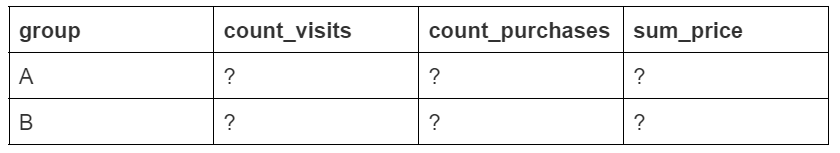
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
updated_data_total = updated_data.groupby(['group'])['user_id', 'purchase', 'price'].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'
                                                             }).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
updated_data_total['sum_price'] = updated_data_total['sum_price'] / 1000000
updated_data_total

C:\Users\Антон\AppData\Local\Temp\ipykernel_6600\2050419496.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  updated_data_total = updated_data.groupby(['group'])['user_id', 'purchase', 'price'].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'


,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417.78
B,145381,17290,1533.01


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений и количество покупок обоих вариантов посадочной страницы сопоставимы, сумма всех покупок в группе В выше, чем в группе А - можно сделать предположение, что средний чек в группе В будет выше. О стабилизации метрик пока говорить рано - необходимо проследить куммулятивные метрики.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
updated_data_total['conversion'] = round(updated_data_total['count_purchases'] /updated_data_total['count_visits'] * 100, 2)
updated_data_total['mean_check'] = round(updated_data_total['sum_price'] / updated_data_total['count_purchases'] * 1000000)
updated_data_total

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417.78,12.03,81076.0
B,145381,17290,1533.01,11.89,88665.0


По конверсии вариант А эффективнее варианта В, но по среднему чеку вариант В показывает результаты лучше

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [11]:
import plotly.express as px
fig = px.imshow(img=(pivot),
          x=list(pivot.columns),
          y=list(pivot.index),
          title='Тепловая карта покупательской способности в группах',
          labels={'x':'price', 'y':'group'},
          text_auto=True)
fig.update_layout(width=1500, height=500)
fig.show()         

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

По построенному графику можно сделать выводы, что покупательская способность участников А выше в категории туров 60000 руб(5271 против 1730 в группе В), но в группе В покупательская способность участников выше более дорогих туров - 100 000 руб(5227 против 1832)

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
updated_dily = updated_data.pivot_table(
    index=['date', 'group'],
    aggfunc={'user_id':'count', 'purchase':'sum', 'price':'sum'}
    ).reset_index()
updated_dily.head()

,date,group,price,purchase,user_id
0,2021-01-02,A,29410000,359,2854
1,2021-01-02,B,29660000,345,2861
2,2021-01-03,A,62000000,748,6596
3,2021-01-03,B,65960000,754,6619
4,2021-01-04,A,64250000,799,6566


In [13]:
updated_dily['convesion'] = round((updated_dily['purchase'] / updated_dily['user_id'] * 100), 2)
updated_dily['check_mean'] = round(updated_dily['price'] / updated_dily['purchase'])
updated_dily = updated_dily.rename(columns={'price':'sum_price', 'user_id':'count_visit', 'purchase':'count_purchases'})
updated_dily.head(4)

,date,group,sum_price,count_purchases,count_visit,convesion,check_mean
0,2021-01-02,A,29410000,359,2854,12.58,81922.0
1,2021-01-02,B,29660000,345,2861,12.06,85971.0
2,2021-01-03,A,62000000,748,6596,11.34,82888.0
3,2021-01-03,B,65960000,754,6619,11.39,87480.0


**Конверсия 03.01.2021:**
- в группе А равна 11,34%
- в группе В равна 11,39%

**Средний чек 03.01.2021:**
- в группе А равен 82888 руб
- в группе В равен 87480 руб

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
updated_dily['count_visit_cum'] = updated_dily.groupby('group')['count_visit'].cumsum() # куммулятивное количество посещений страницы
updated_dily['count_purchases_cum'] = updated_dily.groupby('group')['count_purchases'].cumsum() # куммулятивное количество покупок
updated_dily['sum_price_cum'] = updated_dily.groupby('group')['sum_price'].cumsum() # куммулятивная сумма покупок
updated_dily['conversion_cum'] = round((updated_dily['count_purchases_cum'] / updated_dily['count_visit_cum'] * 100), 2)
updated_dily['check_mean_cum'] = round(updated_dily['sum_price_cum'] / updated_dily['count_purchases_cum'])
updated_dily.tail(10)

,date,group,sum_price,count_purchases,count_visit,convesion,check_mean,count_visit_cum,count_purchases_cum,sum_price_cum,conversion_cum,check_mean_cum
36,2021-01-20,A,58710000,749,6533,11.46,78385.0,121506,14561,1179590000,11.98,81010.0
37,2021-01-20,B,69250000,790,6685,11.82,87658.0,121857,14496,1286900000,11.90,88776.0
38,2021-01-21,A,70300000,851,6750,12.61,82609.0,128256,15412,1249890000,12.02,81098.0
39,2021-01-21,B,69870000,760,6555,11.59,91934.0,128412,15256,1356770000,11.88,88934.0
40,2021-01-22,A,63690000,788,6587,11.96,80825.0,134843,16200,1313580000,12.01,81085.0
41,2021-01-22,B,68660000,787,6659,11.82,87243.0,135071,16043,1425430000,11.88,88851.0
42,2021-01-23,A,70950000,843,6698,12.59,84164.0,141541,17043,1384530000,12.04,81237.0
43,2021-01-23,B,68930000,805,6633,12.14,85627.0,141704,16848,1494360000,11.89,88697.0
44,2021-01-24,A,33250000,444,3766,11.79,74887.0,145307,17487,1417780000,12.03,81076.0
45,2021-01-24,B,38650000,442,3677,12.02,87443.0,145381,17290,1533010000,11.89,88665.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [15]:
fig = px.line(updated_dily, x='date', y='conversion_cum', line_group='group', color='group', title='Куммулятивный график конверсии')
fig.show()

In [16]:
fig2 = px.line(updated_dily, x='date', y='check_mean_cum', line_group='group', color='group', title='Куммулятивный график среднего чека')
fig2.show()

По графикам куммулятивных метрик - конверсия и средний чек в группах начала стабилизироваться после 13.01.2021, метрики стабилизированы для дальнейшего проведения проверки гипотез в двух группах. После стабилизации конверсия в группе А выше конверсии в группе В, но по среднему чеку результаты групппы В эффективнее. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [17]:
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе В'
alpha = 0.05
_, p_value = proportions_ztest(
    count=updated_data_total['count_purchases'],
    nobs=updated_data_total['count_visits'],
    alternative='larger')
print(f'p_value = {round(p_value, 2)}')
if p_value > alpha:
    print(H0)
else:
    print(H1)

p_value = 0.12
Конверсии в группах А и В равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Несмотря на то, что конверсия в группе А больше конверсии в группе В - статистической разницы между ними нет, принимаем гипотезу, что конверсии в группах А и В равны

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [18]:
def proportion(n, x_p, gamma):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [19]:
# доверительный интервал конверсии для группы А
proposition_a = proportion(
    n=updated_dily[updated_dily['group']=='A']['count_visit'].sum(),
    x_p=updated_dily[updated_dily['group']=='A']['convesion'].mean() / 100,
    gamma=0.95
)
proposition_a

(11.88, 12.21)

In [20]:
# доверительный интервал конверсии для группы B
proposition_b = proportion(
    n=updated_dily[updated_dily['group']=='B']['count_visit'].sum(),
    x_p=updated_dily[updated_dily['group']=='B']['convesion'].mean() / 100,
    gamma=0.95
)
proposition_b

(11.73, 12.06)

In [21]:
# функция, рассчитывает доверительный интервал разницы пропорций
def diff_proportions_conf_interval(n, x_p, gamma):
    alpha = 1 - gamma 
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [22]:
# рассчитаем доверительный интервал разницы пропорций в группах
diff_proportions_conf_interval(
    n=[updated_dily[updated_dily['group']=='A']['count_visit'].sum(), updated_dily[updated_dily['group']=='B']['count_visit'].sum()],
    x_p=[(updated_dily[updated_dily['group']=='A']['convesion'].mean() / 100), (updated_dily[updated_dily['group']=='B']['convesion'].mean() / 100)],
    gamma=0.95
)

(-0.38, 0.09)

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Статистический тест показал, что конверии в группах равны, доверительные интервалы подтвердили это - доверительный интервал разницы пропорций охватывает 0(левая граница отрицательная, правая положительная), что означает, что варианты равнозначны по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [23]:
H0 = 'Данные распределены нормально'
H1 = 'Распределение отличное от нормального'
alpha = 0.05

_, p_value_a = shapiro(updated_dily[updated_dily['group']=='A']['check_mean'])
_, p_value_b = shapiro(updated_dily[updated_dily['group']=='B']['check_mean'])
print(f'p_value_a = {round(p_value_a, 2)}, p_value_b = {round(p_value_b, 2)}')

if (p_value_a < alpha) or (p_value_b < alpha):
    print(f'{H1}')
else:
    print(f'{H0}')


p_value_a = 0.25, p_value_b = 0.09
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [24]:
# так как данные распределены нормально, то для сравнения двух средних используем t-тест
from scipy.stats import ttest_ind


H0 = 'Ежедневные средние чеки равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе В'
alpha = 0.05

_, p_value = ttest_ind(
    a = updated_dily[updated_dily['group']=='A']['check_mean'],
    b = updated_dily[updated_dily['group']=='B']['check_mean'],
    alternative = 'less'
)
print(f'p_value = {round(p_value, 2)}')

if p_value > alpha:
    print(f'Принимаем нулевую гипотезу: {H0}')
else:
    print(f'Отвергаем нулевую гипотезу: {H1}')

p_value = 0.0
Отвергаем нулевую гипотезу: Ежедневный средний чек в группе А меньше чем в группе В


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Сравнительный статистический тест для проверки среднего чека в обеих группах показал, что ежедневный средний чек в группе В выше, чем в группе А.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [25]:
def confidence_interval(n, x_mean, x_std, gamma):
    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std / (n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return round(lower_bound), round(upper_bound)

In [26]:
confidence_interval_a = confidence_interval(
    n = updated_dily[updated_dily['group']=='A']['check_mean'].count(),
    x_mean = updated_dily[updated_dily['group']=='A']['check_mean'].mean(),
    x_std = updated_dily[updated_dily['group']=='A']['check_mean'].std(),
    gamma = 0.95
)

confidence_interval_b = confidence_interval(
    n = updated_dily[updated_dily['group']=='B']['check_mean'].count(),
    x_mean = updated_dily[updated_dily['group']=='B']['check_mean'].mean(),
    x_std = updated_dily[updated_dily['group']=='B']['check_mean'].std(),
    gamma = 0.95
)
print(f'Доверительный интервал группы А - {confidence_interval_a}, доверительный интервал групы В - {confidence_interval_b}')

Доверительный интервал группы А - (79630, 82308), доверительный интервал групы В - (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечений в двух группах доверительного интервала нет - что явно доказывает гипотезу о том, что средний чек в группе В выше, чем в группе А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Произведено А/В тестирование двух вариантов посадочных страниц по метрикам: конверсия продаж и по среднему чеку. Тест проводился в период с 02.01.2021 - 24.01.2021, на порядка 145000 визитов в каждой группе, из обоих групп исключены все пользователи, юзавшие два варинта сайта. При проведении статистических тестов метрики стабилизированы. Все статистические тесты проводились при уровни значимости alpha = 0.05.

1. **Конверсия продаж**

Для сравнения двух групп по данной метрике был использовани z-тест для пропорций, который подтвердил нулевую гипотезу - конверсии в обоих группах одинаковые, несмотря на небольшой перевес в значениях в пользу группы А(12,03% против 11,89% в группе В).

2. **Средний чек**

Для сравнения по данной метрике был использован t-тест так как показатель ежедневного среднего чека имеет нормальное распределение. Результат теста - средний ежедневный чек в группе В(88665 руб.) превосходит ежедневный средний чек в группе А(81076 руб.). Отсутствие пересечений доверительных интервалов в каждой группе это подтвердили:  группы А - (79630, 82308), доверительный интервал групы В - (87626, 89526). Связано это с тем, что пользователи в группе В приобретали туры из более дорогой категории(100 тыс. руб.) - в группе В - 5227 туров (против 1832 в группе А), но по приобретению туров из менее дорогой категории(60 тыс. руб.) лидировали пользователи из группы А - 5271 туров против 1730 туров в группе В. По остальным категориям туров ситуация одинаковая в обоих группах. 

Общий вывод по А/В тесту: вариант дизайна посадочной страницы варианта В является более эффективным и предпочтительным - исключительно по метрике "средний чек", пользователи данной группы более платежеспособны и приобретают больше азиатское направление(Таиланд). По конверсии продаж разницы в группах не замечено. Если у компании стоит цель увеличить прибыль и продать более дорогие туры, то однозначно вариант страницы В. Если компании важно оперативно реализовать, например, менее дорогие направления - горящие путёвки в Турцию и увеличить клиентскую базу именно данной категории пользователей возможно оставить вариант А, и вернуться к реализации варианта В позже.